# EEEN30131 Power System Analysis: Week 06 - Primary Voltage Control

***&copy; 2024 Martínez Ceseña — University of Manchester, UK***

This notebook provides several examples covering frequency regulation and generation control, including general `python` code which can be used to solve the examples and create new ones.

The use of the notebooks is optional and will not be marked. That said, you are strongly encouraged to play with the tools and examples, as such activities will better prepare you for the exams.

## List of contents

- [Power flow models](#Power-flow-models)
  - [Backward-Forward Sweep](#Backward-Forward-Sweep)
  - [Adding shunt components](#Adding-shunt-components)
  - [Comparing the power flow simulators](#Comparing-the-power-flow-simulators)
- [Voltage control](#Voltage-control)
  - [Two-bus system example](#Two-bus-system-example)
  - [Power circle diagram](#Power-circle-diagram)
  - [Series compensation](#Series-compensation)
  - [Generators](#Generators)
  - [Tap-changing transformers](#Tap-changing-transformers)

## Before we begin

Before we begin: 
- Make sure to review the asynchronous materials provided in blackboard for EEEN30131 Week 6 - Primary voltage control 

This notebook builds on the materials that were presented in previous sessions. Therefore, make sure to review the asynchronous materials provided in blackboard for EEEN30131:
  - Week 1 - Nodal analysis 
  - Week 2 - Power Flow Formulation 
  - Week 3 - Newton Raphson
  - Week 4 - Frequency regulation
  - Week 5 - Interconnected systems

- If you have any questions, please post them in the discussion boards or, if that is not possible, send an email to alex.martinezcesena@manchester.ac.uk

If this data notebook is being used in Jupyter lite, the folders where the python code that supports this notebook are stored, have to be enabled.

In [1]:
from pathlib import Path
if Path.cwd().drive == '':
    a_dir = Path("dir")
    a_dir.mkdir(exist_ok=True)

The following libraries are required by the notebook:

In [2]:
import cmath
import numpy
import matplotlib.pyplot as plt
import math

The notebook borrows several tools developed in previous weeks, so we need to import them here:

In [3]:
from Code.Wk1_EEEN30131 import get_Ybus
from Code.Wk2_EEEN30131 import get_Bus_Type, develop_PF_Equations
from Code.Wk3_EEEN30131 import Newtons_Method

[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

## Power flow models

### Backward-Forward Sweep

Consider the 2-bus system below, which can represent a power line.

![Week02_2Bus.png](Figures/Week02_2Bus.png)

The power flows in this system can be simulated with the tools developed in previous notebooks.

In [4]:
Connectivity = [
    [1, 2, complex(0, 0.1), 0]
]
Load = [
    [2, complex(0.5, 0.5)]
]
Generator = [
    {'Bus':1, 'V':1, '𝜃':0 }
]

However, there are simpler approaches to simulate the power flows which can take advantages of specific characteristics of some systems. For example, as the system under consideration is radial, we can use the Bakward-Forward Sweep (BFS) approach.

The BFS can be implemented with the following 4 steps:
   1. Initialize voltages at the receiving end assuming flat-start conditions
$$
V_r = 1 \angle 0
$$
   2. Calculate current across the line's impedance as a function of the voltages, assume PQ loads, (backward sweep)
$$
I_z = - \left( \frac{S_r}{V_r} \right) ^* +V_r \frac{B}{2}
$$ 
   3. Calculate new voltages at the receiving end using the calculated current (forward sweep)
$$
V_r = V_s - I_z \times Z
$$
   4. Repeat backward forward sweep until convergence

In [5]:
def bfs(Generator, Connectivity, Load):
    V1 = Generator[0]['V'] * \
        complex(math.cos(Generator[0]['𝜃']),
                math.sin(Generator[0]['𝜃']))
    V2 = complex(1, 0)
    Z = Connectivity[0][2]
    B = complex(0, Connectivity[0][3])
    S2 = -Load[0][1]

    Threshold = cmath.inf
    flg = True
    iterations = 0
    while flg:
        I = -(S2/V2).conjugate() + V2*B/2  # Backward sweep
        Threshold = abs(V2 - V1 + I * Z)  # Calculate error
        V2 = V1 - I * Z  # Forward sweep

        # Convergence criteria
        iterations += 1
        if iterations > 20:
            print('The model failed to converge after 20 iterations')
            flg = False
            Succes = False
        if Threshold < 0.00001:  # Accuracy check
            flg = False
            Succes = True

    V_All = [abs(V1), abs(V2)]
    𝜃_All = [cmath.phase(V1), cmath.phase(V2)]

    return V_All, 𝜃_All, Threshold, Succes

If we compare the outputs of the models, we can see that the results match.

In [6]:
print('************       BFS:        ************')
V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)

print('Voltages according to BFS method:')
for xb, V, 𝜃 in zip(range(len(V_All)), V_All, 𝜃_All):
    print('V%d =  %7.4f ∠ %8.4f [pu][deg]'%(xb+1, V, 𝜃*180/math.pi))

print('\n************ NEWTONs METHOD: ************')
Ybus = get_Ybus(Connectivity, True, False)
P_Data, Q_Data = develop_PF_Equations(Load, Generator, Ybus, True, False)
Bus_Data, Bus_Type = get_Bus_Type(Ybus, Load, Generator)
V_All, 𝜃_All, Threshold, Succes = Newtons_Method(P_Data, Q_Data, Bus_Data, Bus_Type, Generator, 0)

print('Voltages according to BFS method:')
for xb, V, 𝜃 in zip(range(len(V_All)), V_All, 𝜃_All):
    print('V%d =  %7.4f ∠ %8.4f [pu][deg]'%(xb+1, V, 𝜃*180/math.pi))

************       BFS:        ************
Voltages according to BFS method:
V1 =   1.0000 ∠   0.0000 [pu][deg]
V2 =   0.9457 ∠  -3.0306 [pu][deg]

************ NEWTONs METHOD: ************
Voltages according to BFS method:
V1 =   1.0000 ∠   0.0000 [pu][deg]
V2 =   0.9457 ∠  -3.0306 [pu][deg]


[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

### Adding shunt components

As we are now including the shunt line components $B$, it is convenient to update the method used to calculate network parameters, especially the line currents and power flows. For this purpose, it is assumed that half of the shunt susceptance is connected at each edge of each line. This is called the **pi** line model.

In [7]:
def get_Parameters(Connectivity, V_All, 𝜃_All, Succes):
    ''' Calculate additional parameters '''
    if not Succes:
        return

    Base = 100
    Number_Buses = len(V_All)

    Results = {}
    Results['Connectivity'] = Connectivity
    Results['Voltage'] = []
    Results['Current'] = []
    Results['Current2'] = []
    Results['Sending_Power'] = []
    Results['Receiving_Power'] = []
    Results['Net_Power'] = [0 for bus in range(Number_Buses)]
    Results['Loss'] = []
    Results['Generation'] = []

    # Get complex voltages
    for bus in range(Number_Buses):
        Results['Voltage'].append(V_All[bus]*complex(math.cos(𝜃_All[bus]),
                                                     math.sin(𝜃_All[bus])))

    for branch in Connectivity:
        s = branch[0]-1
        r = branch[1]-1
        Y = 1/branch[2]
        B = complex(0, branch[3]/2)

        # Complex voltages
        Vs = Results['Voltage'][s]
        Vr = Results['Voltage'][r]

        # Complex currents
        I = Y * (Vs - Vr)
        I1 = Y * (Vs - Vr) + Vs*B
        I2 = Y * (Vr - Vs) + Vr*B

        # Power at both ends of the line
        Ss0 = Vs*I.conjugate()*Base
        Sr0 = Vr*I.conjugate()*Base
        Ss = Vs*I1.conjugate()*Base
        Sr = Vr*I2.conjugate()*Base

        # Store data
        Results['Current'].append(I1)
        Results['Current2'].append(I2)
        Results['Sending_Power'].append(Ss)
        Results['Receiving_Power'].append(Sr)
        Results['Loss'].append(Ss0-Sr0)
        Results['Net_Power'][s] += Ss
        Results['Net_Power'][r] += Sr

    return Results

Based on the **pi** model, and using an example with two lines, the susceptances can be modelled by placing half the susceptances at each edge of the lines.

Be aware that if $Y = j \frac{B}{2}$ then $Z = -j \frac{2}{B}$ and that the susceptances are assumed to connect the buses and the ground (bus zero).

In [8]:
Connectivity = [
    [1, 2, complex(0.0003, 0.0030), 1.2],
    [2, 3, complex(0.0015, 0.0150), 2.2],
    [1, 0, complex(0, -2/1.2)],
    [2, 0, complex(0, -2/1.2)],
    [2, 0, complex(0, -2/2.2)],
    [3, 0, complex(0, -2/2.2)]
    ]
# From Week 01
Ybus = get_Ybus(Connectivity, True, False)
print('Ybus =')
for Yv in Ybus:
    for Y in Yv:
        print('%10.4f + j %10.4f |'%(Y.real, Y.imag), end='')
    print()

Ybus =
   33.0033 + j  -329.4330 |  -33.0033 + j   330.0330 |    0.0000 + j     0.0000 |
  -33.0033 + j   330.0330 |   39.6040 + j  -394.3396 |   -6.6007 + j    66.0066 |
    0.0000 + j     0.0000 |   -6.6007 + j    66.0066 |    6.6007 + j   -64.9066 |


However, rather than manually adding each shunt component, it is convenient to update the approach used to calculate the $Y_{bus}$ matrix. 

In [9]:
def get_Ybus(Connectivity, flg=False, prnt=True):
    # Get number of branches
    Number_Branches = len(Connectivity)

    # Get number of nodes
    Number_Buses = 0
    for branch in range(Number_Branches):
        Number_Buses = \
            max([Number_Buses, Connectivity[branch][0],
                 Connectivity[branch][1]])

    # Display network data
    if prnt:
        print('The network has %d branches and %d buses' %
              (Number_Branches, Number_Buses))
        print('______________________________')
        print('Branch | From - To | Impedance')
        print('------------------------------')
        for branch in range(Number_Branches):
            print('%5.0f  | %4.0f - %2.0f |' %
                  (branch+1, Connectivity[branch][0], Connectivity[branch][1]),
                  end=' ')
            print(Connectivity[branch][2])
        print('_______|___________|__________')

    # Build Ybus matrix
    Ybus = numpy.zeros((Number_Buses, Number_Buses), dtype=complex)
    for branch in range(Number_Branches):
        From = Connectivity[branch][0] - 1
        To = Connectivity[branch][1] - 1

        Y = 1/Connectivity[branch][2]
        B = complex(0, Connectivity[branch][3])

        if From >= 0 and To >= 0:
            Ybus[From][To] = -Y
            Ybus[To][From] = -Y

        if From >= 0:
            Ybus[From][From] += Y + B/2

        if To >= 0:
            Ybus[To][To] += Y + B/2

    if prnt:
        print('\nYbus = \n', Ybus)
    if flg:
        return Ybus

Connectivity = [
    [1, 2, complex(0.0003, 0.0030), 1.2],
    [2, 3, complex(0.0015, 0.0150), 2.2]
    ]
# From Week 01
Ybus = get_Ybus(Connectivity, True, False)
print('Ybus =')
for Yv in Ybus:
    for Y in Yv:
        print('%10.4f + j %10.4f |'%(Y.real, Y.imag), end='')
    print()

Ybus =
   33.0033 + j  -329.4330 |  -33.0033 + j   330.0330 |    0.0000 + j     0.0000 |
  -33.0033 + j   330.0330 |   39.6040 + j  -394.3396 |   -6.6007 + j    66.0066 |
    0.0000 + j     0.0000 |   -6.6007 + j    66.0066 |    6.6007 + j   -64.9066 |


[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

### Comparing the power flow simulators

We can now compare both methods with case studies that include shunt components.

In [10]:
Connectivity = [
    [1, 2, complex(0, 0.1), 2.2]
]
Load = [
    [2, complex(0.5, 0.5)]
]
Generator = [
    {'Bus':1, 'V':1, '𝜃':0 }
]
print('************       BFS:        ************')
V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)

print('Voltages according to BFS method:')
for xb, V, 𝜃 in zip(range(len(V_All)), V_All, 𝜃_All):
    print('V%d =  %7.4f ∠ %8.4f [pu][deg]'%(xb+1, V, 𝜃*180/math.pi))

print('\n************ NEWTONs METHOD: ************')
Ybus = get_Ybus(Connectivity, True, False)
P_Data, Q_Data = develop_PF_Equations(Load, Generator, Ybus, True, False)
Bus_Data, Bus_Type = get_Bus_Type(Ybus, Load, Generator)
V_All, 𝜃_All, Threshold, Succes = Newtons_Method(P_Data, Q_Data, Bus_Data, Bus_Type, Generator, 0)

print('Voltages according to BFS method:')
for xb, V, 𝜃 in zip(range(len(V_All)), V_All, 𝜃_All):
    print('V%d =  %7.4f ∠ %8.4f [pu][deg]'%(xb+1, V, 𝜃*180/math.pi))

************       BFS:        ************
Voltages according to BFS method:
V1 =   1.0000 ∠   0.0000 [pu][deg]
V2 =   1.0699 ∠  -2.6787 [pu][deg]

************ NEWTONs METHOD: ************
Voltages according to BFS method:
V1 =   1.0000 ∠   0.0000 [pu][deg]
V2 =   1.0699 ∠  -2.6787 [pu][deg]


[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

## Voltage control

### Two-bus system example

Consider the system presented below.
- What can you do to adjust the voltage in bus 2?
- What happens if the load changes or becomes negative (e.g., distributed generation)?
- Try to keep the voltage at 0.95 pu as you change the loads, is that easy to do?

![Week02_2Bus.png](Figures/Week02_2Bus.png)

In [11]:
def VC_01(P, Q, V):

    Connectivity = [
        [1, 2, complex(0, 0.1), 0]
    ]
    Load = [
        [2, complex(P, Q)]
    ]
    Generator = [
        {'Bus': 1, 'V': V, '𝜃': 0}
    ]
    V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)
    for xb, V, 𝜃 in zip(range(len(V_All)), V_All, 𝜃_All):
        print('V%d =  %7.4f ∠ %8.4f [pu][deg]' % (xb+1, V, 𝜃*180/math.pi))

In [12]:
P = 0.5  # Consider values between -5 and 5
Q = 0.5  # Consider values between -5 and 5
V = 1  # Consider values between 0.95 and 1.05

VC_01(P, Q, V)

V1 =   1.0000 ∠   0.0000 [pu][deg]
V2 =   0.9457 ∠  -3.0306 [pu][deg]


[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

### Power circle diagram

From the example above, there is an evident connection between voltage drops and active and reactive power at both ends of the line (sending and receiving ends). However, it can be unclear and, therefore, it is convenient to visualize it. For this purpose, let us take a closer look at the 2-bus system which can represent a power line.

When analysing the power flows across the line, it may be deduced that the relationship between the sending end (Bus 1) power and the receiving end (Bus2) powers can be expressed as
$$
V_s = V_r + ZI_r\\
I_s = I_r
$$

This relationship between sending and receiving voltages can be plotted as circles. This is known as the sending end and receiving end **power circle** diagrams. We will create methods to create and plot the diagrams below.

In [13]:
def get_power_circle(V_All, Connectivity):
    '''Method to create power circle diagrams'''
    # Radius
    radius = abs(V_All[0]) * abs(V_All[1]) / abs(Connectivity[0][2])
    Ph = cmath.phase(Connectivity[0][2])

    # Sending end
    aux = abs(V_All[0])**2/abs(Connectivity[0][2])
    centreS = [aux * numpy.cos(Ph), aux * math.sin(Ph)]

    # Receiving end
    aux = -abs(V_All[1])**2/abs(Connectivity[0][2])
    centreR = [aux * numpy.cos(Ph), aux * math.sin(Ph)]

    return radius, centreR, centreS

def plot_circles(centreR, centreS, radius, Point1=[None], Point2=[None],
                 Axes=[None]):
    '''Method to plot both powe circle diagrams'''
    circle1 = plt.Circle(centreS, radius, color='b', fill=False)
    circle2 = plt.Circle(centreR, radius, color='b', fill=False)
    fig, ax = plt.subplots()
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    plt.grid(linestyle='--')
    plt.xlabel('Real power [pu]')
    plt.ylabel('Reactive power [pu]')
    if Axes[0] is None:
        ax.set_xlim((min([centreS[0], centreR[0]])-radius,
                     max([centreS[0], centreR[0]])+radius))
        ax.set_ylim((min([centreS[1], centreR[1]])-radius,
                     max([centreS[1], centreR[1]])+radius))
    else:
        ax.set_xlim((Axes[0], Axes[1]))
        ax.set_ylim((Axes[2], Axes[3]))
    if Point1[0] is not None:
        plt.plot(Point1[0], Point1[1], marker='o', label='Load')
    if Point2[0] is not None:
        plt.plot(Point2[0], Point2[1], marker='o', label='Generation')
    plt.legend()
    plt.show()

Now that we have our tools, let us use a 2-bus example and plot both power circle diagrams.

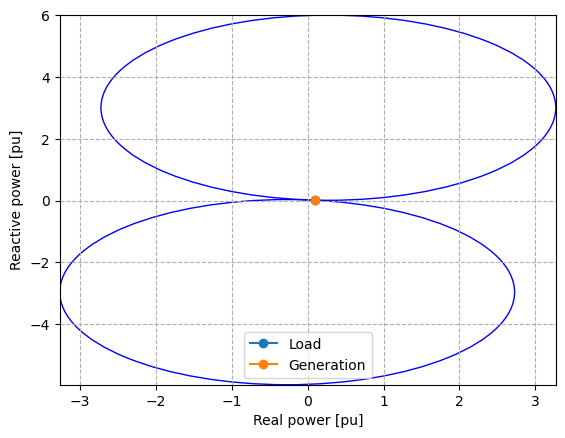

In [14]:
Connectivity = [
    [1, 2, complex(0.03, 0.33), 0]
]
Load = [
    [2, complex(0.1, 0.01)]
]
Generator = [
    {'Bus':1, 'V':1, '𝜃':0 }
]

#
V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)
radius, centreR, centreS = get_power_circle(V_All, Connectivity)
Results = get_Parameters(Connectivity, V_All, 𝜃_All, Succes)
Vs = V_All[0]
Vr = V_All[1]
P = Load[0][1].real
Q = Load[0][1].imag
PG = Results['Net_Power'][0].real/100
QG = Results['Net_Power'][0].imag/100
plot_circles(centreR, centreS, radius, [P, Q], [PG, QG])

[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

> So, how do we use the power circles?

Based on the receiving end power circle diagram, once we **fix the voltage at the sending end**, the voltage at the receiving end will remain the same for any PQ **load** combinations (in bus 2) on the perimeter of the circle.

In [15]:
def PCR_02(P, Q):

    global centreR, centreS, radius, Connectivity, Generator, Vr
    Load = [
        [2, complex(P, Q)]
    ]
    Axes = [0, 1, -0.3, 0.1]
    print('Adjust the load, especially Q2, to keep V2 at %.4f pu' % Vr)

    V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)
    Results = get_Parameters(Connectivity, V_All, 𝜃_All, Succes)
    for xb, V, 𝜃 in zip(range(len(V_All)), V_All, 𝜃_All):
        print('  V%d =  %7.4f ∠ %8.4f [pu][deg]' % (xb+1, V, 𝜃*180/math.pi))

    y1 = (radius**2 - (P - centreR[0])**2)**0.5 + centreR[1]
    y2 = -(radius**2 - (P - centreR[0])**2)**0.5 + centreR[1]
    print('Consider Q2 = %.4f or Q2 = %.4f' % (y1, y2))
    PG = Results['Net_Power'][0].real/100
    QG = Results['Net_Power'][0].imag/100

    plot_circles(centreR, centreS, radius, [P, Q], [PG, QG], Axes)

Adjust the load, especially Q2, to keep V2 at 0.9931 pu
  V1 =   1.0000 ∠   0.0000 [pu][deg]
  V2 =   0.9931 ∠  -1.8869 [pu][deg]
Consider Q2 = 0.0100 or Q2 = -5.9384


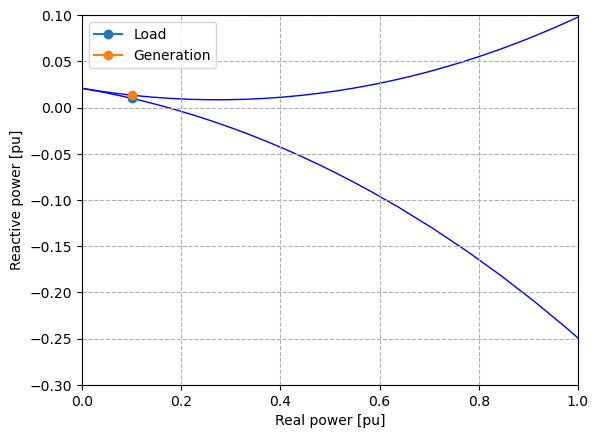

In [16]:
P = 0.1  # Consider values between 0 and 1
Q = 0.01  # Consider values between -0.3 and 0.1

PCR_02(P, Q)

Based on the sending end power circle diagram, once we **fix the voltage at the receiving** end, the voltage at the sending end will remain the same for any PQ **generation** combinations (in bus 1) on the perimeter of the circle.

In [17]:
def PCR_01(PG, QG):

    global centreR, centreS, radius, Connectivity, Vs
    Load = [
        [2, complex(-PG, -QG)]
    ]
    Generator = [
        {'Bus': 1, 'V': Vr, '𝜃': 0}
    ]
    Axes = [0, 1, -0.3, 0.1]

    print('Adjust generation, especially Q1, to keep V1 at %.4f pu' % Vs)
    V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)
    Results = get_Parameters(Connectivity, V_All, 𝜃_All, Succes)
    print('  V%d =  %7.4f ∠ %8.4f [pu][deg]' % (1, V_All[1],
                                                𝜃_All[0]*180/math.pi))
    print('  V%d =  %7.4f ∠ %8.4f [pu][deg]' % (2, V_All[0],
                                                -1*𝜃_All[1]*180/math.pi))

    y1 = -(radius**2 - (PG - centreS[0])**2)**0.5 + centreS[1]
    y2 = (radius**2 - (PG - centreS[0])**2)**0.5 + centreS[1]
    print('Consider Q1 = %.4f or Q1 = %.4f' % (y1, y2))
    P = -Results['Net_Power'][0].real/100
    Q = -Results['Net_Power'][0].imag/100
    plot_circles(centreR, centreS, radius, [P, Q], [PG, QG], Axes)

Adjust generation, especially Q1, to keep V1 at 1.0000 pu
  V1 =   1.0000 ∠   0.0000 [pu][deg]
  V2 =   0.9931 ∠  -1.8812 [pu][deg]
Consider Q1 = 0.0134 or Q1 = 5.9975


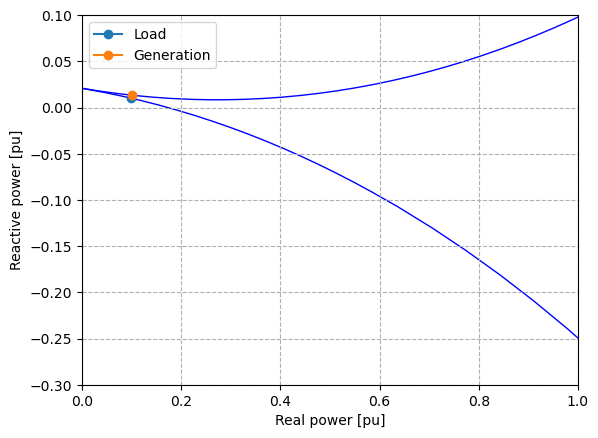

In [18]:
PG = 0.1  # Considering values between 0 and 1
QG = 0.0133  # Consider values between 0 and 0.1

PCR_01(PG, QG)

The power circle diagrams and examples above can be used to explore inpacts on voltages from
- Different types of loads, including inductive loads, reactors, capacitors, etc.
- Traditional and distributed generators, condensers, etc.

[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

### Series compensation

The voltage drop across a line can be mitigated by connecting capacitors in series to the lines. This can be explored by simulating the power flows across the lines (using the tools developed in previous notebooks) subject to different line impedances. However, let us also try to visualize the effects of the impedances on the voltages using phasor diagrams.

In [19]:
def plot_vector(Ogn, Vec, ax=None, Nme=None, Coor=[0, 0]):
    '''Plot a vector'''

    V = [Vec.real, Vec.imag]

    plt.quiver(Ogn[0], Ogn[1], V[0], V[1], angles='xy', scale_units='xy',
               scale=1)

    if ax is not None:
        ax.annotate(Nme, xy=(Ogn[0]+V[0]/2+Coor[0], Ogn[1]+V[1]/2+Coor[1]),
                    fontsize=12)

    return [min([Ogn[1], Ogn[1]+V[1]]), max(Ogn[1], Ogn[1]+V[1])], \
        [Ogn[0]+V[0], Ogn[1]+V[1]]
    
def plot_phasor(Results, Connectivity):
    fig, ax = plt.subplots()
    Origin = [0, 0]

    mm = []
    m, Es = plot_vector(Origin, Results['Voltage'][0], ax, 'V1')
    mm.append(m)
    m, Er = plot_vector(Origin, Results['Voltage'][1], ax, 'V2')
    mm.append(m)
    m, _ = plot_vector(Origin, Results['Current'][0], ax, 'I')
    mm.append(m)
    VR = Results['Current'][0]*Connectivity[0][2].real
    m, OR = plot_vector(Er, VR, ax, 'IR')
    mm.append(m)
    VX = Results['Current'][0]*complex(0, Connectivity[0][2].imag)
    m, _ = plot_vector(OR, VX, ax, 'jIX')
    mm.append(m)
    lim = [1000, -1000]
    for m in mm:
        lim[0] = min(lim[0], m[0])
        lim[1] = max(lim[1], m[1])
    plt.grid()
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(lim[0], lim[1]+.001)
    plt.show()

We can now use the phasor diagram to see how the voltage drops across the resistance and reactance of the lines.
> Try different values for R and X and check how the voltages change.

In [20]:
def Phasor_01(R, X):
    Connectivity = [
        [1, 2, complex(R, X), 0]
    ]
    Load = [
        [2, complex(0.1, 0.01)]
    ]
    Generator = [
        {'Bus': 1, 'V': 1, '𝜃': 0}
    ]
    V_All, 𝜃_All, Threshold, Succes = bfs(Generator, Connectivity, Load)
    if not Succes:
        print('The model failed to converge')
    Results = get_Parameters(Connectivity, V_All, 𝜃_All, Succes)
    print('  V%d =  %7.4f ∠ %8.4f [pu][deg]' % (1, V_All[0],
                                                𝜃_All[0]*180/math.pi))
    print('  V%d =  %7.4f ∠ %8.4f [pu][deg]' % (2, V_All[1],
                                                𝜃_All[1]*180/math.pi))
    print('  I  =  %7.4f ∠ %8.4f [pu][deg]' % (abs(Results['Current'][0]),
                                               cmath.phase(Results['Current']
                                                           [0])*180/math.pi))
    plot_phasor(Results, Connectivity)

  V1 =   1.0000 ∠   0.0000 [pu][deg]
  V2 =   0.9864 ∠  -1.6847 [pu][deg]
  I  =   0.1019 ∠  -7.3953 [pu][deg]


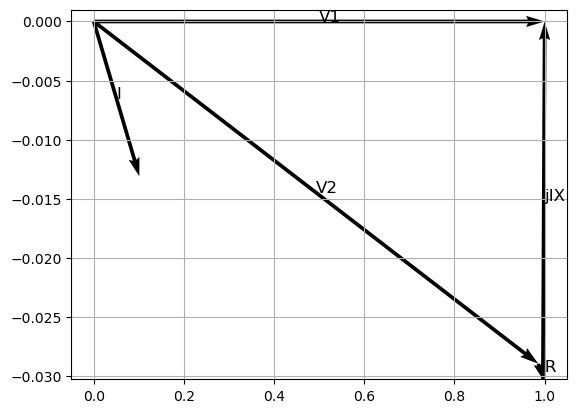

In [21]:
R = 0.1  # Consider values between -1 and 1
X = 0.3  # Consider values between -1 and 1

Phasor_01(R, X)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

### Generators

Synchronous generators can provide voltage support by absorbind or producing reactive power. This is achieved by the automatic voltage regulator (AVR) through adjustments of the field exitation current. A diagram of the generator is presented below.

![Week06_Generator_Phasor.png](Figures/Week06_Generator_Phasor.png)

> Adjust the field exitation current and check how the voltage output of the generator (V) changes

In [22]:
def plot_phasor_Gen(Th):
    Ik = 0.4
    Ang = Th/180*math.pi
    X = complex(0, 0.5)

    aux = Ik/math.cos(Ang)
    I = complex(Ik, aux*math.sin(Ang))

    V = complex(1, 0)
    IX = -I*X
    E = V-IX

    fig, ax = plt.subplots()
    Origin = [0, 0]
    m, _ = plot_vector(Origin, V, ax, 'V')
    m, Er = plot_vector(Origin, E, ax, 'E')
    m, _ = plot_vector(Er, IX, ax, 'jIX')
    m, _ = plot_vector(Origin, I, ax, 'I')

    ax.set_xlim(-0.05, 1.07)
    ax.set_ylim(-0.1, 0.25)
    plt.grid()
    print('  V =  %7.4f ∠ %8.4f [pu][deg]' %
          (abs(V), cmath.phase(V)*180/math.pi))
    print('  E =  %7.4f ∠ %8.4f [pu][deg]' %
          (abs(E), cmath.phase(E)*180/math.pi))
    print('  I =  %7.4f ∠ %8.4f [pu][deg]' %
          (abs(I), cmath.phase(I)*180/math.pi))
    if Th == 0:
        print('Normal excitation')
    elif Th > 0:
        print('Under-excited')
    else:
        print('Overexcited')

  V =   1.0000 ∠   0.0000 [pu][deg]
  E =   1.0164 ∠  11.3485 [pu][deg]
  I =   0.4001 ∠   1.0000 [pu][deg]
Under-excited


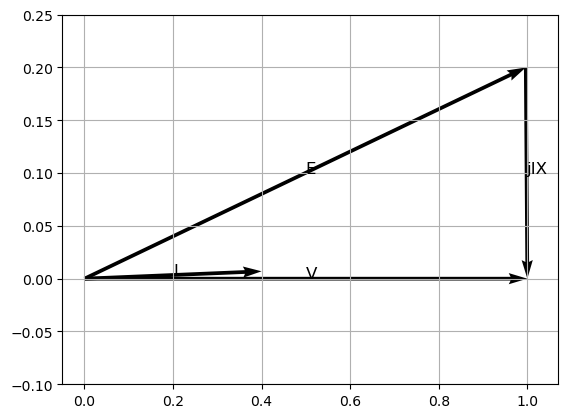

In [23]:
Th = 1  # Consider values between -10 and 10

plot_phasor_Gen(Th)

[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)

### Tap-changing transformers

Tap-changing transformers can be used to provide voltage support by adjusting their turns ratio through changes to the transformer tap position.

![Week06_Transformer.png](Figures/Week06_Transformer.png)

> Adjust the turns ratio (t) and check how the voltages change.

In [24]:
def Phasor_Gen(t):
    B = 5
    # Y = complex(0, B)
    Ybus = [[-t**2*B, t*B], [t*B, -B]]
    Load = [
        [2, complex(0.5, 0.5)]
    ]
    Generator = [
        {'Bus': 1, 'V': .95, '𝜃': 0}
    ]

    P_Data, Q_Data = develop_PF_Equations(Load, Generator, Ybus, True, False)
    Bus_Data, Bus_Type = get_Bus_Type(Ybus, Load, Generator)
    V_All, 𝜃_All, Threshold, Succes = Newtons_Method(P_Data, Q_Data, Bus_Data,
                                                     Bus_Type, Generator, 0)
    print('Vs =  %7.4f ∠ %8.4f [pu][deg]' % (V_All[0], 𝜃_All[0]*180/math.pi))
    print('Vp =  %7.4f ∠ %8.4f [pu][deg]' % (V_All[1], 𝜃_All[1]*180/math.pi))

In [25]:
t = 0.9055  # Consider values between 0.85 and 1.05
    
Phasor_Gen(t)

Vs =   0.9500 ∠   0.0000 [pu][deg]
Vp =   0.9582 ∠  -6.9681 [pu][deg]


[Back to top](#EEEN30131-Power-System-Analysis:-Week-06---Primary-Voltage-Control)